### Solve Gearbox Ratios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D
import time
from matplotlib.offsetbox import AnchoredText 
import mplcursors 
import os
import json
from gearbox import Gearbox

import itertools

from tqdm import tqdm

In [2]:
config = {
  "MODULE": 0.8e-3,
  "MC": 0.8467e-3,
  "MU": 0.21,
  "ALPHA": 20,
  "XS": 0.476,
  "XP1": 0.762,
  "XP2": 0.536,
  "XR1": 2,
  "XR2": 1.21,
  "XS_RANGE": [-0.5, 0.5, 0.25],
  "XP1_RANGE": [-1, 1, 0.25],
  "XP2_RANGE": [-0.5, 0.5, 0.25],
  "XR2_RANGE": [-1.5, 1.5, 0.25],
  "N_PLANETS": 3,
  "SUN_LIMITS": [4, 26],
  "P1_LIMITS": [32, 42],
  "P2_LIMITS": [25, 35],
  "R2_LIMITS": [70,86],
  "STEPS": [2, 1, 1, 1],
  "MIN_RATIO_THRESHOLD": 90,
  "MIN_FORWARD_THRESHOLD": 0.30,
  "MIN_BACKWARD_THRESHOLD": 0.30
}


In [3]:
MODULE = config["MODULE"]
MU = config["MU"]
MC = config.get("MC", MODULE)
ALPHA = np.radians(config.get("ALPHA", 20))
XR1 = config.get("XR1", 0.0)
N_PLANETS = config["N_PLANETS"]
SUN_LIMITS = tuple(config["SUN_LIMITS"])
P1_LIMITS  = tuple(config["P1_LIMITS"])
P2_LIMITS  = tuple(config["P2_LIMITS"])
R2_LIMITS  = tuple(config["R2_LIMITS"])
STEPS = tuple(config["STEPS"])
MIN_RATIO_THRESHOLD = config["MIN_RATIO_THRESHOLD"]
MIN_FORWARD_THRESHOLD = config["MIN_FORWARD_THRESHOLD"]
MIN_BACKWARD_THRESHOLD = config["MIN_BACKWARD_THRESHOLD"]

SLICE_GEAR_RATIO = True 
TARGET_GEAR_RATIO = 100
RATIO_TOLERANCE = 10
DISPLAY_BEST_GEARBOX = False
DISPLAY_ITERATIONS_PLOT = True
RUN_SAMPLE_TRIAL = False
MAX_CANDIDATES = 1000

In [4]:
def generate_options(lower: int, upper: int, step: int = 1):
    return list(range(lower, upper + 1, step))

def generate_range_options(range_vals):
    low, high, step = range_vals
    opts = []
    current = low
    while current <= high + 1e-9:
        opts.append(round(current, 5))
        current += step
    return opts

def generate_all_options(sun_limits: tuple, p1_limits: tuple, p2_limits: tuple, r2_limits: tuple, 
                         steps: tuple = (1,1,1,1)):
    step_sun, step_p1, step_p2, step_r2 = steps
    return {
        "sun": generate_options(sun_limits[0], sun_limits[1], step_sun),
        "p1": generate_options(p1_limits[0], p1_limits[1], step_p1),
        "p2": generate_options(p2_limits[0], p2_limits[1], step_p2),
        "r2": generate_options(r2_limits[0], r2_limits[1], step_r2)
    }

In [5]:
options = generate_all_options(SUN_LIMITS, P1_LIMITS, P2_LIMITS, R2_LIMITS, STEPS)
sun_options = options["sun"]
p1_options  = options["p1"]
p2_options  = options["p2"]
r2_options  = options["r2"]
xs_options = generate_range_options(config["XS_RANGE"])
xp1_options = generate_range_options(config["XP1_RANGE"])
xp2_options = generate_range_options(config["XP2_RANGE"])
xr2_options = generate_range_options(config["XR2_RANGE"])

In [6]:
def view_vector(input_vector, subsample, title, y_lims=None):
    fig, ax = plt.subplots()
    to_plot = input_vector[::subsample]
    xs = np.arange(len(to_plot))
    ax.scatter(xs, to_plot)
    ax.set_title(title)
    if y_lims:
        ax.set_ylim(y_lims)
    plt.show()

C:\Users\campb\AppData\Local\Temp\ipykernel_1516\1621522565.py:21: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / gr_s
C:\Users\campb\AppData\Local\Temp\ipykernel_1516\1621522565.py:48: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / gr_s


Of 66183975 total inputs, there are 3844 valid combinations
Efficiency shapes: (3844,), (3844,)
Average Forward Efficiency: 0.5073 +/- 0.1211
Average Backward Efficiency: 0.2048 +/- 0.2161


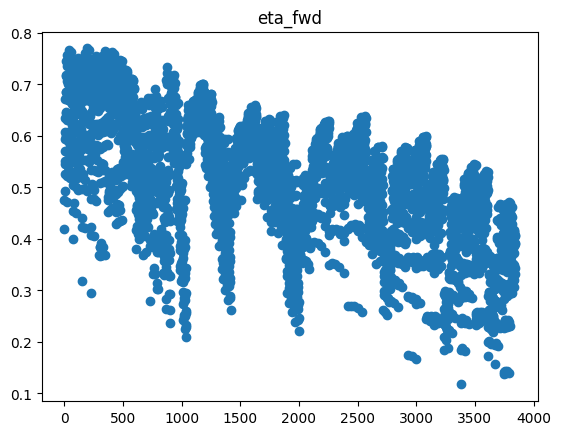

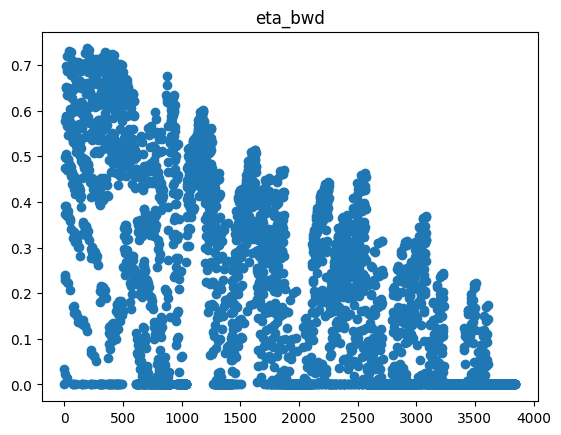

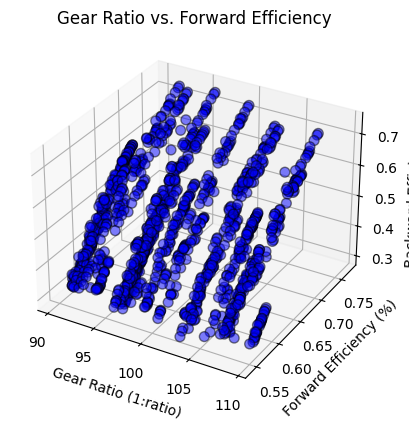

Parameters (z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2): [ 6  8 10 12 14 16 18], [36 37 38 39 40 41 42], [27 28 29 30 31 32 33], [70 71 72 73 74 75 76 77 78 79 80 81 82 83 84], [-0.5  -0.25  0.    0.25  0.5 ], [-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ], [-0.5  -0.25  0.    0.25  0.5 ], [-1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25
  1.5 ]


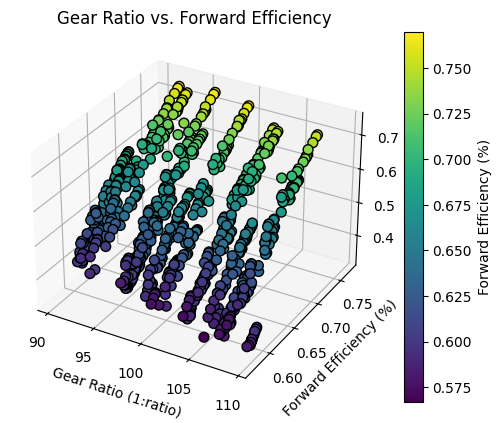

In [7]:
# Calculate z_r1 for each combination of z_s and z_p1
z_s, z_p1 = np.meshgrid(sun_options, p1_options, indexing='ij')
z_r1 = z_s + 2 * z_p1

target_z_r1 = 90

valid_indices = np.where(z_r1 == target_z_r1)
filtered_z_s = z_s[valid_indices]
filtered_z_p1 = z_p1[valid_indices]

# Calculate all possible combinations of gear ratios
z_s, z_p1, z_p2, z_r2 = np.meshgrid(
    filtered_z_s, filtered_z_p1, p2_options, r2_options, indexing='ij'
)

z_r1 = target_z_r1

I1 = z_r1 / z_s
I2 = (z_r1 * z_p2) / (z_p1 * z_r2)
gr_s = (1 - I2) / (1 + I1)
ratios = 1 / gr_s

valid_combinations = np.logical_and(gr_s > 0, np.abs(TARGET_GEAR_RATIO - ratios) <= RATIO_TOLERANCE)

filt_z_s = np.unique(z_s[valid_combinations])
filt_z_p1 = np.unique(z_p1[valid_combinations])
filt_z_p2 = np.unique(z_p2[valid_combinations])
filt_z_r2 = np.unique(z_r2[valid_combinations])


z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = np.meshgrid(
    filt_z_s, filt_z_p1, filt_z_p2, filt_z_r2, xs_options, xp1_options, xp2_options, xr2_options, indexing='ij'
)

# flatten
z_s = z_s.flatten()
z_p1 = z_p1.flatten()
z_p2 = z_p2.flatten()
z_r2 = z_r2.flatten()
xs = xs.flatten()
xp1 = xp1.flatten()
xp2 = xp2.flatten()
xr2 = xr2.flatten()

I1 = z_r1 / z_s
I2 = (z_r1 * z_p2) / (z_p1 * z_r2)
gr_s = (1 - I2) / (1 + I1)
ratios = 1 / gr_s

total_combinations = z_s.size

valid_combinations = np.logical_and(np.logical_and(gr_s > 0, np.abs(TARGET_GEAR_RATIO - ratios) <= RATIO_TOLERANCE), z_s + 2 * z_p1 == z_r1)

# only keep valid combinations (ratios w.in tolerance)
tol = 0.1 # let's start with 0.1, the allowable tolerance in table III is 0.09 as a reference.

# Stage 2 constraint Ring 2 + Planet 2
# Derived equation: (z_r2 - z_p2) = (MODULE/MC) * (z_s + z_p1 + 2 * (xs + xp1)) - 2 * (xr2 - xp2)
ls_stage2 = z_r2 - z_p2 # left side of eq
rs_stage2 = (MODULE / MC) * (z_s + z_p1 + 2 * (xs + xp1)) - 2 * (xr2 - xp2) # right side of eq

# TODO: check if this is the right way to include x values, right now im going off the equations from this page
# https://www.tec-science.com/mechanical-power-transmission/involute-gear/profile-shift/#:~:text=Profile%20shift%20coefficient,For%20the%20corresponding%20diameters%20applies:

stage_2_constraint = np.abs(ls_stage2 - rs_stage2) < tol # check with tolerance 

# check it again with existing valid combos...
valid_combinations = np.logical_and(valid_combinations, stage_2_constraint)

# z_r1 = z_r1[valid_combinations]
z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = z_s[valid_combinations], z_p1[valid_combinations], z_p2[valid_combinations], z_r2[valid_combinations], xs[valid_combinations], xp1[valid_combinations], xp2[valid_combinations], xr2[valid_combinations]
I1, I2, gr_s, ratios = I1[valid_combinations], I2[valid_combinations], gr_s[valid_combinations], ratios[valid_combinations]

assert z_s.shape == z_p1.shape == z_p2.shape == z_r2.shape == xs.shape == xp1.shape == xp2.shape == xr2.shape == ratios.shape

print(f'Of {total_combinations} total inputs, there are {len(z_s)} valid combinations')

ra = (z_s * MODULE + z_p1 * MODULE) / 2.0

# Basic circle diameters
db_a1 = MODULE * z_s * np.cos(ALPHA)
db_a2 = MODULE * z_p1 * np.cos(ALPHA)
db_b1 = MODULE * z_p1 * np.cos(ALPHA)
db_b2 = MODULE * target_z_r1 * np.cos(ALPHA)
db_c1 = MC * z_p2 * np.cos(ALPHA)
db_c2 = MC * z_r2 * np.cos(ALPHA)

# Working pressure angles (modified formula)
alpha_wa = np.arccos(MODULE * (z_s + z_p1) * np.cos(ALPHA) / (2 * ra))
alpha_wb = np.arccos(MODULE * (-z_p1 + target_z_r1) * np.cos(ALPHA) / (2 * ra)) # why is this constant??
val = MC * (-z_p2 + z_r2) * np.cos(ALPHA) / (2 * ra)
alpha_wc = np.arccos(np.clip(val, -1, 1))
# Center distance modification coefficient
ya = ((z_s + z_p1) / 2.0) * ((np.cos(ALPHA) / np.cos(alpha_wa)) - 1)
# Tip circle diameters
das  = MODULE * z_s + 2 * MODULE * (1 + ya - xp1)
dap1 = MODULE * z_p1 + 2 * MODULE * (1 + np.minimum(ya - xs, xp1))
dar1 = MODULE * target_z_r1 - 2 * MODULE * (1 - XR1)
dap2 = MC * z_p2 + 2 * MC * (1 + xp2)
dar2 = MC * z_r2 - 2 * MC * (1 - xr2)
# Tip pressure angles
alpha_aa1 = np.arccos(db_a1 / das)
alpha_aa2 = np.arccos(db_a2 / dap1)
alpha_ab1 = np.arccos(db_b1 / dap1)
alpha_ab2 = np.arccos(db_b2 / dar1)
alpha_ac1 = np.arccos(db_c1 / dap2)
val2 = db_c2 / dar2
alpha_ac2 = np.arccos(np.clip(val2, -1, 1))
# Approach and recess contact ratios
ea1 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_aa2) - np.tan(alpha_wa))
ea2 = (z_s / (2 * np.pi)) * (np.tan(alpha_aa1) - np.tan(alpha_wa))
eb1 = -(target_z_r1 / (2 * np.pi)) * (np.tan(alpha_ab2) - np.tan(alpha_wb))
eb2 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_ab1) - np.tan(alpha_wb))
ec1 = -(z_r2 / (2 * np.pi)) * (np.tan(alpha_ac2) - np.tan(alpha_wc))
ec2 = (z_p2 / (2 * np.pi)) * (np.tan(alpha_ac1) - np.tan(alpha_wc))
ea = ea1**2 + ea2**2 - ea1 - ea2 + 1
eb = eb1**2 + eb2**2 - eb1 - eb2 + 1
ec = ec1**2 + ec2**2 - ec1 - ec2 + 1
# Basic driving efficiencies
Ea_val = 1 - MU* np.pi * (1 / z_s + 1 / z_p1) * ea
Eb_val = 1 - MU* np.pi * (1 / z_p1 - 1 / target_z_r1) * eb
Ec_val = 1 - MU* np.pi * (1 / z_p2 - 1 / z_r2) * ec
# Forward driving efficiency 
eta_fwd = (1 + Ea_val * Eb_val * I1) * (1 - I2) / ((1 + I1) * (1 - Eb_val * Ec_val * I2))
# Backward driving efficiency
def eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val):
    return (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))
def eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val):
    return (1 + I1)*Ea_val*(1-Eb_val*Ec_val*I2)/((Ea_val+Eb_val*I1)*(1-I2))
eta_bwd = np.where(I2 > 1, eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val), eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val))
# eta_bwd = (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))

# filter high eta_bwd
eta_bwd = np.where(eta_bwd > 1, 0, eta_bwd)
eta_bwd = np.where(eta_bwd < 0, 0, eta_bwd)

# Average and std for eta
avg_fwd = np.mean(eta_fwd)
std_fwd = np.std(eta_fwd)
avg_bwd = np.mean(eta_bwd)
std_bwd = np.std(eta_bwd)
print(f'Efficiency shapes: {eta_fwd.shape}, {eta_bwd.shape}')
print(f"Average Forward Efficiency: {avg_fwd:.4f} +/- {std_fwd:.4f}")
print(f"Average Backward Efficiency: {avg_bwd:.4f} +/- {std_bwd:.4f}")

view_vector(eta_fwd, 1, "eta_fwd")
view_vector(eta_bwd, 1, "eta_bwd")

composite_score = ratios * eta_fwd * eta_bwd

bd_indices = np.where(eta_bwd > 0.3)

# create a list of the n (Max_Candidates) best scores
# sort all vectors by composite score
sorted_indices = np.argsort(composite_score)[::-1]
# sorted_indices = np.argsort(eta_bwd)[::-1]
best_indices = sorted_indices[:MAX_CANDIDATES]

# make 'best' versions of all the arrays
best_z_s = z_s[best_indices]
best_z_p1 = z_p1[best_indices]
best_z_r1 = z_r1
best_z_p2 = z_p2[best_indices]
best_z_r2 = z_r2[best_indices]
best_xs = xs[best_indices]
best_xp1 = xp1[best_indices]
best_xp2 = xp2[best_indices]
best_xr2 = xr2[best_indices]
best_ratios = ratios[best_indices]
best_eta_fwd = eta_fwd[best_indices]
best_eta_bwd = eta_bwd[best_indices]
best_composite_score = composite_score[best_indices]

# look at 

ss = 87
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(ratios[bd_indices], eta_fwd[bd_indices], eta_bwd[bd_indices], c='b', edgecolor='k', alpha=0.5, s=50)
ax.set_xlabel("Gear Ratio (1:ratio)")
ax.set_ylabel("Forward Efficiency (%)")
ax.set_zlabel("Backward Efficiency (%)")
ax.set_title("Gear Ratio vs. Forward Efficiency")
plt.show()

# print paramaters included in best vals
print(f'Parameters (z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2): {np.unique(best_z_s)}, {np.unique(best_z_p1)}, {np.unique(best_z_p2)}, {np.unique(best_z_r2)}, {np.unique(best_xs)}, {np.unique(best_xp1)}, {np.unique(best_xp2)}, {np.unique(best_xr2)}')

# plot: Gear ratio, forward efficiency, backward efficiency (color forward efficiency)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(best_ratios, best_eta_fwd, best_eta_bwd, c=best_eta_fwd, cmap='viridis', edgecolor='k', alpha=1, s=50)
ax.set_xlabel("Gear Ratio (1:ratio)")
ax.set_ylabel("Forward Efficiency (%)")
ax.set_zlabel("Backward Efficiency (%)")
ax.set_title("Gear Ratio vs. Forward Efficiency")
fig.colorbar(sc, label="Forward Efficiency (%)")
plt.show()


In [8]:
# check how many valid values are included

# plot: Gear ratio, forward efficiency, backward efficiency (don't worry about score)
bd_indices = np.where(eta_bwd > 0.3)

valid_z_s = np.unique(z_s[bd_indices])
valid_z_p1 = np.unique(z_p1[bd_indices])
valid_z_p2 = np.unique(z_p2[bd_indices])
valid_z_r2 = np.unique(z_r2[bd_indices])
valid_xs = np.unique(xs[bd_indices])
valid_xp1 = np.unique(xp1[bd_indices])
valid_xp2 = np.unique(xp2[bd_indices])
valid_xr2 = np.unique(xr2[bd_indices])

print(f'z_p1 vals: {valid_z_p1}')
print(f'z_s vals: {valid_z_s}')
print(f'z_p2 vals: {valid_z_p2}')
print(f'z_r2 vals: {valid_z_r2}')
print(f'x_s vals: {valid_xs}')
print(f'x_p1 vals: {valid_xp1}')
print(f'x_p2 vals: {valid_xp2}')
print(f'x_r2 vals: {valid_xr2}')

# 'high enough' bwd efficiency:
valid_vals = [valid_z_s, valid_z_p1, valid_z_p2, valid_z_r2, valid_xs, valid_xp1, valid_xp2, valid_xr2]
meshgrid_vals = [z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2]
meshgrid_names = ['z_s', 'z_p1', 'z_p2', 'z_r2', 'xs', 'xp1', 'xp2', 'xr2']

# data structure: dictionary. key: variable name, value: (parameter value, valid count)
validity_dict = {}
# for each variable (i.e. z_s)
for ind, check_vals in enumerate(valid_vals):
    param_val = []
    valid_count = []
    # look at each possible value (each value with at least 1 valid entry)
    for val in check_vals:
        param_val.append(val) # record value
        valid_count.append(np.count_nonzero(meshgrid_vals[ind][bd_indices] == val))  # Count occurrences in valid set
    validity_dict[meshgrid_names[ind]] = (param_val, valid_count)


z_p1 vals: [35 36 37 38 39 40 41 42]
z_s vals: [ 6  8 10 12 14 16 18 20]
z_p2 vals: [27 28 29 30 31 32 33]
z_r2 vals: [70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85]
x_s vals: [-0.5  -0.25  0.    0.25  0.5 ]
x_p1 vals: [-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]
x_p2 vals: [-0.5  -0.25  0.    0.25  0.5 ]
x_r2 vals: [-1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25
  1.5 ]


In [9]:
# print frequencies
for key in list(validity_dict.keys()):
    print(f'{key}')
    for ind in range(len(validity_dict[key][0])):
        print(validity_dict[key][0][ind], validity_dict[key][1][ind])

z_s
6 473
8 90
10 10
12 54
14 238
16 238
18 167
20 28
z_p1
35 28
36 167
37 238
38 238
39 54
40 10
41 90
42 473
z_p2
27 65
28 148
29 179
30 278
31 396
32 190
33 42
z_r2
70 70
71 78
72 73
73 70
74 55
75 54
76 57
77 70
78 99
79 75
80 156
81 135
82 110
83 121
84 67
85 8
xs
-0.5 214
-0.25 253
0.0 284
0.25 278
0.5 269
xp1
-1.0 161
-0.75 153
-0.5 145
-0.25 126
0.0 136
0.25 124
0.5 144
0.75 153
1.0 156
xp2
-0.5 224
-0.25 259
0.0 280
0.25 277
0.5 258
xr2
-1.5 30
-1.25 41
-1.0 72
-0.75 87
-0.5 107
-0.25 122
0.0 132
0.25 148
0.5 138
0.75 127
1.0 107
1.25 95
1.5 92


In [10]:
best_dict = {}

for key in list(validity_dict.keys()):
    # print(f'{key}')
    # find the best 4 scores
    targ_len = 4
    best_scores = np.zeros([targ_len,1])
    for ind in range(len(validity_dict[key][1])):
       score = validity_dict[key][1][ind]
       if (score > best_scores).any():
            min_ind = np.argmin(best_scores)
            best_scores[min_ind] = score
    low_score = np.min(best_scores)
    best_vals = []
    best_scores = []
    for ind in range(len(validity_dict[key][0])):
        if validity_dict[key][1][ind] >= low_score:
            # print((validity_dict[key][0][ind], validity_dict[key][1][ind]))
            best_vals.append(validity_dict[key][0][ind])
            best_scores.append(validity_dict[key][1][ind])
    best_dict[key] = (best_vals, best_scores)
        


In [11]:
for key in list(best_dict.keys()):
    print(f'{key}')
    for ind in range(len(best_dict[key][0])):
        print(best_dict[key][0][ind], best_dict[key][1][ind])

z_s
6 473
14 238
16 238
18 167
z_p1
36 167
37 238
38 238
42 473
z_p2
29 179
30 278
31 396
32 190
z_r2
80 156
81 135
82 110
83 121
xs
-0.25 253
0.0 284
0.25 278
0.5 269
xp1
-1.0 161
-0.75 153
0.75 153
1.0 156
xp2
-0.25 259
0.0 280
0.25 277
0.5 258
xr2
0.0 132
0.25 148
0.5 138
0.75 127


In [12]:
# re-run meshgrid and validity check with values from optimization

in_vals = [] #list of arrays
for key in list(best_dict.keys()):
    in_vals.append(np.array(best_dict[key][0]))

# Calculate all possible combinations of gear ratios

z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = np.meshgrid(
    *in_vals, indexing='ij'
)

z_r1 = target_z_r1

# flatten
z_s = z_s.flatten()
z_p1 = z_p1.flatten()
z_p2 = z_p2.flatten()
z_r2 = z_r2.flatten()
xs = xs.flatten()
xp1 = xp1.flatten()
xp2 = xp2.flatten()
xr2 = xr2.flatten()

I1 = z_r1 / z_s
I2 = (z_r1 * z_p2) / (z_p1 * z_r2)
gr_s = (1 - I2) / (1 + I1)
ratios = 1 / gr_s

total_combinations = z_s.size

valid_combinations = np.logical_and(np.logical_and(gr_s > 0, np.abs(TARGET_GEAR_RATIO - ratios) <= RATIO_TOLERANCE), z_s + 2 * z_p1 == z_r1)

# z_r1 = z_r1[valid_combinations]
z_s, z_p1, z_p2, z_r2, xs, xp1, xp2, xr2 = z_s[valid_combinations], z_p1[valid_combinations], z_p2[valid_combinations], z_r2[valid_combinations], xs[valid_combinations], xp1[valid_combinations], xp2[valid_combinations], xr2[valid_combinations]
I1, I2, gr_s, ratios = I1[valid_combinations], I2[valid_combinations], gr_s[valid_combinations], ratios[valid_combinations]

assert z_s.shape == z_p1.shape == z_p2.shape == z_r2.shape == xs.shape == xp1.shape == xp2.shape == xr2.shape == ratios.shape

print(f'Of {total_combinations} total inputs, there are {len(z_s)} valid combinations')

ra = (z_s * MODULE + z_p1 * MODULE) / 2.0

# Basic circle diameters
db_a1 = MODULE * z_s * np.cos(ALPHA)
db_a2 = MODULE * z_p1 * np.cos(ALPHA)
db_b1 = MODULE * z_p1 * np.cos(ALPHA)
db_b2 = MODULE * target_z_r1 * np.cos(ALPHA)
db_c1 = MC * z_p2 * np.cos(ALPHA)
db_c2 = MC * z_r2 * np.cos(ALPHA)

# Working pressure angles (modified formula)
alpha_wa = np.arccos(MODULE * (z_s + z_p1) * np.cos(ALPHA) / (2 * ra))
alpha_wb = np.arccos(MODULE * (-z_p1 + target_z_r1) * np.cos(ALPHA) / (2 * ra)) # why is this constant??
val = MC * (-z_p2 + z_r2) * np.cos(ALPHA) / (2 * ra)
alpha_wc = np.arccos(np.clip(val, -1, 1))
# Center distance modification coefficient
ya = ((z_s + z_p1) / 2.0) * ((np.cos(ALPHA) / np.cos(alpha_wa)) - 1)
# Tip circle diameters
das  = MODULE * z_s + 2 * MODULE * (1 + ya - xp1)
dap1 = MODULE * z_p1 + 2 * MODULE * (1 + np.minimum(ya - xs, xp1))
dar1 = MODULE * target_z_r1 - 2 * MODULE * (1 - XR1)
dap2 = MC * z_p2 + 2 * MC * (1 + xp2)
dar2 = MC * z_r2 - 2 * MC * (1 - xr2)
# Tip pressure angles
alpha_aa1 = np.arccos(db_a1 / das)
alpha_aa2 = np.arccos(db_a2 / dap1)
alpha_ab1 = np.arccos(db_b1 / dap1)
alpha_ab2 = np.arccos(db_b2 / dar1)
alpha_ac1 = np.arccos(db_c1 / dap2)
val2 = db_c2 / dar2
alpha_ac2 = np.arccos(np.clip(val2, -1, 1))
# Approach and recess contact ratios
ea1 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_aa2) - np.tan(alpha_wa))
ea2 = (z_s / (2 * np.pi)) * (np.tan(alpha_aa1) - np.tan(alpha_wa))
eb1 = -(target_z_r1 / (2 * np.pi)) * (np.tan(alpha_ab2) - np.tan(alpha_wb))
eb2 = (z_p1 / (2 * np.pi)) * (np.tan(alpha_ab1) - np.tan(alpha_wb))
ec1 = -(z_r2 / (2 * np.pi)) * (np.tan(alpha_ac2) - np.tan(alpha_wc))
ec2 = (z_p2 / (2 * np.pi)) * (np.tan(alpha_ac1) - np.tan(alpha_wc))
ea = ea1**2 + ea2**2 - ea1 - ea2 + 1
eb = eb1**2 + eb2**2 - eb1 - eb2 + 1
ec = ec1**2 + ec2**2 - ec1 - ec2 + 1
# Basic driving efficiencies
Ea_val = 1 - MU* np.pi * (1 / z_s + 1 / z_p1) * ea
Eb_val = 1 - MU* np.pi * (1 / z_p1 - 1 / target_z_r1) * eb
Ec_val = 1 - MU* np.pi * (1 / z_p2 - 1 / z_r2) * ec
# Forward driving efficiency 
eta_fwd = (1 + Ea_val * Eb_val * I1) * (1 - I2) / ((1 + I1) * (1 - Eb_val * Ec_val * I2))
# Backward driving efficiency
def eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val):
    return (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))
def eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val):
    return (1 + I1)*Ea_val*(1-Eb_val*Ec_val*I2)/((Ea_val+Eb_val*I1)*(1-I2))
eta_bwd = np.where(I2 > 1, eta_bwd2(I1, I2, Ea_val, Eb_val, Ec_val), eta_bwd1(I1, I2, Ea_val, Eb_val, Ec_val))
# eta_bwd = (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))

# filter high eta_bwd
eta_bwd = np.where(eta_bwd > 1, 0, eta_bwd)
eta_bwd = np.where(eta_bwd < 0, 0, eta_bwd)

# Average and std for eta
avg_fwd = np.mean(eta_fwd)
std_fwd = np.std(eta_fwd)
avg_bwd = np.mean(eta_bwd)
std_bwd = np.std(eta_bwd)

# view_vector(eta_fwd, 1, "eta_fwd")
# view_vector(eta_bwd, 1, "eta_bwd")

composite_score = ratios * eta_fwd * eta_bwd

bd_indices = np.where(eta_bwd > 0.3)

print(f'Efficient enough indices: {len(z_s[bd_indices])}')



Of 65536 total inputs, there are 2816 valid combinations
Efficient enough indices: 1025


C:\Users\campb\AppData\Local\Temp\ipykernel_1516\1931057458.py:28: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / gr_s


In [16]:
import sys

start_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from utils import score_vals

In [17]:
# check that function returns same value
in_vals = [] #list of arrays
for key in list(best_dict.keys()):
    in_vals.append(np.array(best_dict[key][0]))

new_vals = []
for i in range(len(in_vals)):
    if i != 1:
        new_vals.append(in_vals[i])

this_score = score_vals(new_vals)
print(this_score)

151


c:\Users\campb\Python_Code\Mod_DOE\utils.py:54: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / gr_s
c:\Users\campb\Python_Code\Mod_DOE\utils.py:80: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / gr_s


In [24]:
#generate all possible subsets

num_per_param = 3

sun_options = options["sun"]
p1_options  = options["p1"]
p2_options  = options["p2"]
r2_options  = options["r2"]
xs_options = generate_range_options(config["XS_RANGE"])
xp1_options = generate_range_options(config["XP1_RANGE"])
xp2_options = generate_range_options(config["XP2_RANGE"])
xr2_options = generate_range_options(config["XR2_RANGE"])


all_params = [sun_options, p2_options, r2_options, xs_options, xp1_options, xp2_options, xr2_options]

ss_vals = []

for param in all_params:
    ss_vals.append(list(itertools.combinations(param, num_per_param)))



In [ ]:
#create loop to run all possible in_vals
high_score = 0
best_vals = []
for combination_of_vals in itertools.product(*ss_vals):
    score = score_vals(list(combination_of_vals))
    if score > high_score:
        best_vals = combination_of_vals
        high_score = score

[[ 4.    6.    8.  ]
 [25.   26.   27.  ]
 [70.   71.   72.  ]
 [-0.5  -0.25  0.  ]
 [-1.   -0.75 -0.5 ]
 [-0.5  -0.25  0.  ]
 [-1.5  -1.25 -1.  ]]
[[ 4.    6.    8.  ]
 [25.   26.   27.  ]
 [70.   71.   72.  ]
 [-0.5  -0.25  0.  ]
 [-1.   -0.75 -0.5 ]
 [-0.5  -0.25  0.  ]
 [-1.5  -1.25 -0.75]]
[[ 4.    6.    8.  ]
 [25.   26.   27.  ]
 [70.   71.   72.  ]
 [-0.5  -0.25  0.  ]
 [-1.   -0.75 -0.5 ]
 [-0.5  -0.25  0.  ]
 [-1.5  -1.25 -0.5 ]]
[[ 4.    6.    8.  ]
 [25.   26.   27.  ]
 [70.   71.   72.  ]
 [-0.5  -0.25  0.  ]
 [-1.   -0.75 -0.5 ]
 [-0.5  -0.25  0.  ]
 [-1.5  -1.25 -0.25]]
[[ 4.    6.    8.  ]
 [25.   26.   27.  ]
 [70.   71.   72.  ]
 [-0.5  -0.25  0.  ]
 [-1.   -0.75 -0.5 ]
 [-0.5  -0.25  0.  ]
 [-1.5  -1.25  0.  ]]
[[ 4.    6.    8.  ]
 [25.   26.   27.  ]
 [70.   71.   72.  ]
 [-0.5  -0.25  0.  ]
 [-1.   -0.75 -0.5 ]
 [-0.5  -0.25  0.  ]
 [-1.5  -1.25  0.25]]
[[ 4.    6.    8.  ]
 [25.   26.   27.  ]
 [70.   71.   72.  ]
 [-0.5  -0.25  0.  ]
 [-1.   -0.75 -0.5 ]
 [-0.5 

KeyboardInterrupt: 

In [ ]:
z_s = [6, 8, 10, 12]
z_p2 = [32, 31, 30, 33]
z_r2 = [78, 80, 81, 77]
x_s = [0.4, 0.6, 0.45, 0.55]
x_p1 = [0.7, 0.9, 0.75, 0.85]
x_p2 = [0.35, 0.4, 0.3, 0.45]
x_r2 = [1.0, 0.9, 1.1, 0.8]

Yi_vals = [z_s, z_p2, z_r2, x_s, x_p1, x_p2, x_r2] #list of arrays

score_vals(Yi_vals)


Of 12288 total inputs, there are 3584 valid combinations


2227

In [ ]:
z_s = [6, 10, 8, 12]
z_p1 = [42, 40, 41, 39]
z_p2 = [32, 31, 30, 33]
z_r2 = [80, 78, 77, 82]
x_s = [0.45, 0.4, 0.5, 0.55]
x_p1 = [0.7, 0.75, 0.8, 0.85]
x_p2 = [0.3, 0.2, 0.4, 0.5]
x_r2 = [1.2, 0.8, 1.0, 0.6]

Yi_vals = [z_s, z_p2, z_r2, x_s, x_p1, x_p2, x_r2] #list of arrays

score_vals(Yi_vals)

Of 16384 total inputs, there are 3584 valid combinations


1984

In [ ]:
1984 / 2628

0.7549467275494672